In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import train test split fromo sklearn
from sklearn.model_selection import train_test_split
import pycountry_convert
from pipeline_functions import *
import copy
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# dane = pd.read_excel('/Users/adammajczyk/Dokumenty-lokalne/DANE/online_retail_II.xlsx')
dane = pd.read_excel('online_retail_II.xlsx')

In [3]:
dane = initial_transform(dane)

In [4]:
dane = add_continent_and_eu_columns(dane)

In [5]:
dane

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Year,Day,TotalPrice,YearMonth,is_logged,Continent
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,12,2009,1,83.40,2009-12,1,EU_UK
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009,1,81.00,2009-12,1,EU_UK
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009,1,81.00,2009-12,1,EU_UK
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,12,2009,1,100.80,2009-12,1,EU_UK
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,12,2009,1,30.00,2009-12,1,EU_UK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,12,2010,9,5.90,2010-12,1,EU_UK
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,12,2010,9,3.75,2010-12,1,EU_UK
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,12,2010,9,3.75,2010-12,1,EU_UK
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,12,2010,9,7.50,2010-12,1,EU_UK


In [6]:
#split data in train test validation 0.8 0.1 0.1
train, test = train_test_split(dane, test_size=0.2)
train, val = train_test_split(train, test_size=0.125)


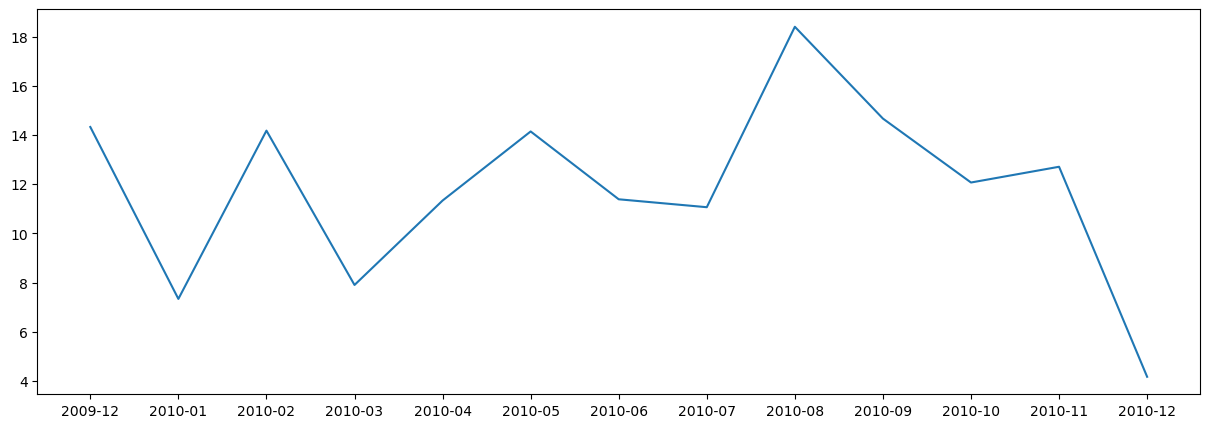

In [7]:
# plot price by date on x axis for stockcode 20979
plt.figure(figsize=(15,5))
plt.plot(train[train['StockCode'] == 20979].groupby('YearMonth')['Quantity'].mean())




<Figure size 1000x600 with 0 Axes>

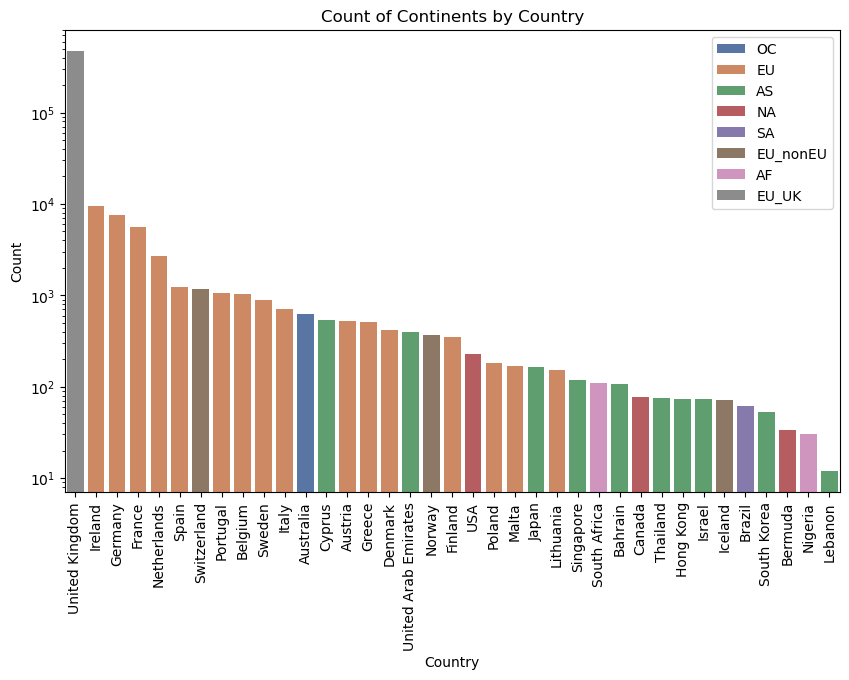

In [8]:
warnings.filterwarnings("ignore")
continent_counts = dane.groupby('Country')['Continent'].value_counts().reset_index(name='Count')
sorted_countries = continent_counts.groupby('Country').sum().sort_values(by='Count', ascending=False).index

plt.figure(figsize=(10, 6))

# Create a bar plot
plt.figure(figsize=(10, 6))

sns.barplot(x='Country', y='Count', hue='Continent', data=continent_counts,
            palette='deep', dodge=False, order=sorted_countries)

# Set labels and title
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Count of Continents by Country')
plt.yscale("log")
# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Add legend
plt.legend()

# Show the plot
plt.show()
warnings.filterwarnings("default")


In [9]:
df = add_moving_mean_columns(dane)

In [10]:
df

,Year,Month,StockCode,Continent,quantity_month_continent,quantity_month_worldwide,mean_worldwide,weighted_mean_worldwide,mean_continent,weighted_mean_continent,price_unlogged,price_logged
0,2009,12,10002,EU,108,216,216.000000,216.000000,108.000000,108.000000,1.700000,0.850000
1,2009,12,10002,EU_UK,108,216,216.000000,216.000000,108.000000,108.000000,1.700000,0.850000
2,2009,12,10080,EU_UK,4,4,4.000000,4.000000,4.000000,4.000000,1.700000,0.850000
3,2009,12,10109,EU_UK,4,4,4.000000,4.000000,4.000000,4.000000,0.840000,0.420000
4,2009,12,10120,EU_UK,115,115,115.000000,115.000000,115.000000,115.000000,0.430000,0.210000
...,...,...,...,...,...,...,...,...,...,...,...,...
51257,2010,12,DCGS0076,EU_UK,1,1,1.333333,1.296875,1.333333,1.296875,16.130000,8.065000
51258,2010,12,DOT,EU_UK,21,21,45.333333,39.898193,45.333333,39.898193,609.684286,304.842143
51259,2010,12,M,EU_UK,119,119,224.000000,205.012695,184.000000,115.193624,463.570000,4.822778
51260,2010,12,POST,EU,96,98,251.333333,198.305420,37.666667,74.312135,39.942857,19.971429
